In [1]:
from collections import Counter
import os
import pandas as pd
from collections import Counter
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.ensemble import (RandomForestClassifier,
                              GradientBoostingClassifier)
from sklearn.model_selection import RandomizedSearchCV
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import ADASYN, SMOTE, SMOTENC
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc, f1_score, roc_auc_score, balanced_accuracy_score

## Data Preparation

In [2]:
#os.listdir('./data/')

In terminal at current directory where association files from GWAS run in PLINK are present run:

head -2000 logistic_results.assoc_2.logistic.adjusted | awk '{ print $2 }' >> top2000_snps.txt 

top2000_snps.txt has the top 2000 SNPs associated with CN_AD GWAS logistic analysis

Now extract only the top 2000 snps geneomic data for CN_AD subjects {in GWAS_ADNI/CN_AD/QualityControl/}

plink --bfile GWAS_1_2_3_clean_CN_AD12 --make-bed --out GWAS_1_2_3_final_CN_AD12 #to make sure the files are sorted

NOTE: GWAS_1_2_3_clean_CN_AD12 is the final plink file set obtained after Quality Control Analysis

plink --bfile GWAS_1_2_3_final_CN_AD12 --extract top2000_snps.txt --recode --make-bed --out GWAS_CN_AD12

Finally we have GWAS_CN_AD12.ped file which contain genotype information in single line for each subject

FID,IID,FatherID,MotherID,Sex,Phenotype,Genotype:{Minor allele, Major allele} Sequence
starting from column 7 In the the form of pair minor allele and major allele. 

Which means

minor allele for snp1 is 7 and major allele for snp1 is 8;

minor allele for snp1 is 9 and major allele for snp1 is 10; 

and so on

Note: The missing genotypes are encoded with 00

In [3]:
df = pd.read_csv('./data/ADNIMERGE.csv',low_memory=False)
df_bl = df[df['VISCODE']=='bl']

In [4]:
print(Counter(df[df['VISCODE']=='bl']['DX_bl']))

Counter({'LMCI': 651, 'CN': 518, 'AD': 398, 'EMCI': 389, 'SMC': 301, nan: 12})


In [5]:
with open('./data/GWAS_CN_AD12.fam','r') as infile:
    text = infile.read().strip().split('\n')

PTID = [line.strip().split(' ')[1] for line in text]
    

In [6]:
df_GWAS = df_bl[pd.DataFrame(df_bl.PTID.tolist()).isin(PTID).any(1).values]

In [7]:
print(set(df_GWAS.PTID) == set(PTID))

True


In [8]:
print(Counter(df_GWAS['DX_bl']))

Counter({'CN': 325, 'AD': 195})


Prepare Genotype dataset as a matrix (195+325) x (2000 + 1(age) + 1(gender) + 1(education) + 1(Baseline Diagnosis) ) = 520 x 2004

In [9]:
def sequence_parser(t):
    
    t1 = [t[i].strip() for i in range(len(t)) if i%2 !=0]
    t2 = [t[i].strip() for i in range(len(t)) if i%2 ==0]
    Geno = [t1[i]+t2[i] for i in range(len(t1))]
    
    return Geno

In [10]:
data = []
with open('./data/GWAS_CN_AD12.ped','r') as infile:   
    text = infile.read().strip().split('\n')
    for line in text:
        gene = line.split(' ')[6:]
        PTID = line.split(' ')[1]
        AGE = df_GWAS[df_GWAS['PTID'] == PTID].AGE.item()
        GENDER = df_GWAS[df_GWAS['PTID'] == PTID].PTGENDER.item()
        EDU = df_GWAS[df_GWAS['PTID'] == PTID].PTEDUCAT.item()
        DIAG = df_GWAS[df_GWAS['PTID'] == PTID].DX_bl.item()
        GENOME = sequence_parser(gene)
        output = [PTID] + [AGE] + [GENDER] + [EDU] + [DIAG]+ GENOME
        data.append(output)
        
    

In [11]:
with open('./data/top2000_snps.txt') as infile:
    snps = infile.read().strip().split('\n')

In [12]:
column_names = ['PTID','AGE','GENDER','EDU']+['DIAG']+snps

In [13]:
df_final = pd.DataFrame(data,columns=column_names)
df_final.to_csv('./data/GWAS12_data_Dx_bl.csv')

In [14]:
#Number of top SNPs to take as features
N = 50
import pandas as pd
from collections import Counter

In [15]:
df_final = pd.read_csv('./data/GWAS_data_Dx_bl.csv',na_values=["00"])
df_final = df_final.iloc[:, 0:N+6] #Only top N snps
df_final = df_final.drop(columns=['Unnamed: 0'])
df_final.dropna(inplace=True)
print(Counter(df_final.DIAG))

Counter({'CN': 319, 'AD': 188})


In [16]:
from sklearn.preprocessing import LabelBinarizer
def prepare_targets(y):
    le = LabelBinarizer()
    le.fit(y)
    y = le.transform(y)
    return y

#Very inefficient approach! but is easier to visualize in my head
def data_prep(df): #This takes the dataframe and returns the one hot encoded expansion of input features
    target = prepare_targets(list(df.DIAG))
    df1 = df.drop(columns=['PTID','DIAG']).reset_index(drop=True) #Patient ID and DIAG not needed
    num_cols = ['AGE','EDU']
    cat_cols = list(set(df1.columns) - set(num_cols)) #Categorical features
    expand_cat = ['AGE','EDU'] #List of expanded categorical columns
    for cat in cat_cols:
        expand_cat = expand_cat + [str(cat)+'_'+ c for c in list(set(df1[cat]))]
    df_out = pd.DataFrame(columns=list(expand_cat))
    df_out['AGE'] = df1.AGE
    df_out['EDU'] = df1.EDU
    for i in range(len(df1)):
        row = df1.iloc[i]
        for col in cat_cols:
            item = row[col]
            df_out.at[i,str(col)+'_'+ item] = str(1)
        
    df_out = df_out.fillna(str(0))
    return df_out, target.ravel()
df, y = data_prep(df_final)
print(df.shape, y.shape)

(507, 154) (507,)


## Recursive Feature Selections

In [25]:
estimator = GradientBoostingClassifier(random_state=1,n_estimators=2*df.shape[1])
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
selector = RFECV(estimator, n_jobs=-1,step=1, cv=cv)
selector = selector.fit(df, y)

In [18]:
df = df.loc[:, selector.support_]
print(df.shape)

(507, 114)


In [19]:
final_N = df.shape[1]

In [20]:
cat_columns = list(set(df.columns) - set(['AGE','EDU']))

In [21]:
cat_columns_index = range(2,df.shape[1])

# Classifier

## Hyperparameters Grid Search

Adapted from https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/

Best Score: 0.7600271791885072
Best Hyperparameters: {'n_estimators': 250}
Automatically created module for IPython interactive environment


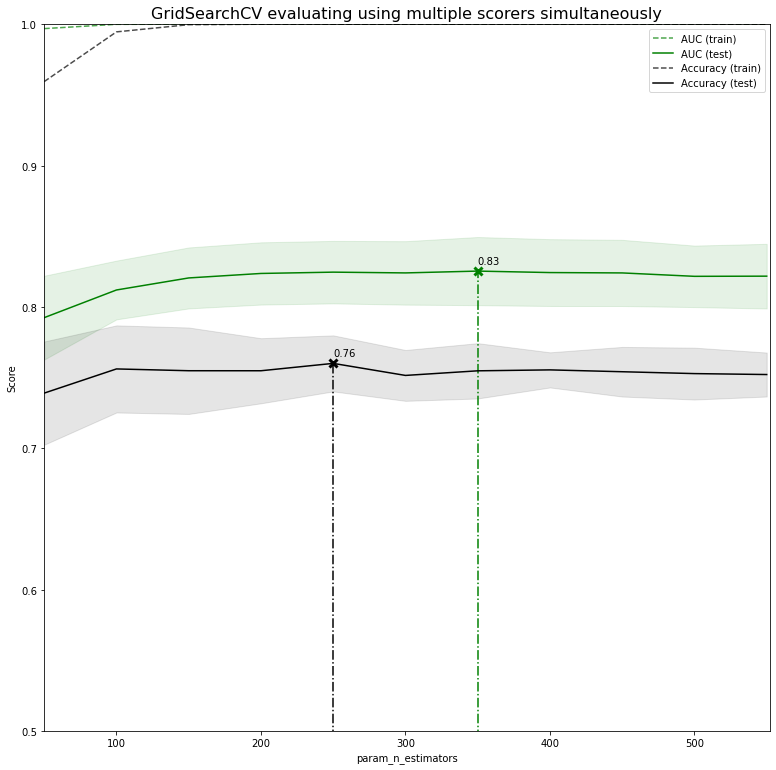

In [23]:
#Adapted from #https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html#sphx-glr-auto-examples-model-selection-plot-multi-metric-evaluation-py

# Author: Raghav RV <rvraghav93@gmail.com>
# License: BSD
groups = 'CN_AD'
model = Pipeline([
        ('sampling', SMOTENC(sampling_strategy=0.7, k_neighbors=7, categorical_features = cat_columns_index,random_state=1)),
        ('classifier', GradientBoostingClassifier(random_state=1))
    ])
space = dict()
X, y = df, y
# define model
model = GradientBoostingClassifier(random_state=1)
# define evaluation
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
# define search space
space = dict()
space['n_estimators'] = range(50,5*X.shape[1],50)

scoring = {'AUC': 'roc_auc', 'Accuracy':'accuracy'}
# define search
search = GridSearchCV(model, space,n_jobs=-1, cv=cv,scoring=scoring, refit='Accuracy', return_train_score=True)
# execute search
result = search.fit(X, y)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)
results = search.cv_results_

print(__doc__)
plt.figure(figsize=(13, 13))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously",
          fontsize=16)

plt.xlabel("param_n_estimators")
plt.ylabel("Score")

ax = plt.gca()
ax.set_xlim(min(space['n_estimators']), max(space['n_estimators'])+2)
ax.set_ylim(0.50, 1)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_n_estimators'].data, dtype=float)

for scorer, color in zip(sorted(scoring), ['g', 'k']):
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
        sample_score_std = results['std_%s_%s' % (sample, scorer)]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

    best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = results['mean_test_%s' % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
                (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid(False)
plt.savefig('./results/Grid_search_Using_Genomic_for:'+groups+'.png')

## Final Run and Save Results

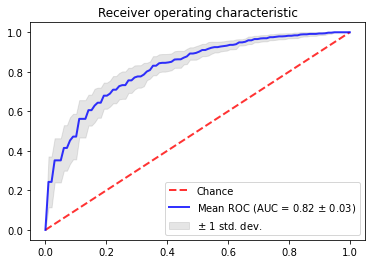

for total of  114 Features
Mean Balanced Accuracy: 0.7324406761084393
Mean AUC: 0.8217884472818683
END OF THE EXPERIMENT


<Figure size 432x288 with 0 Axes>

In [24]:
tprs = []
aucs = []
acc = []
imp = []
mean_fpr = np.linspace(0, 1, 100)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
fig, ax = plt.subplots()
X, y = df, y
for train, test in cv.split(X, y):
    X_train = X.iloc[train]
    y_train = y[train]
    
    X_test = X.iloc[test]
    y_test = y[test]
    n_estimators = result.best_params_['n_estimators']
    model = GradientBoostingClassifier(random_state=1,n_estimators=n_estimators)
    oversample = SMOTENC(sampling_strategy=0.7, k_neighbors=7, categorical_features = cat_columns_index,random_state=1)
    X_train, y_train = oversample.fit_resample(X_train, y_train)
    probas_ = model.fit(X_train, y_train).predict_proba(X_test)
    y_pred = model.predict(X_test)
    acc.append(balanced_accuracy_score(y_test, y_pred))
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1],drop_intermediate='False')
    roc_auc = roc_auc_score(y_test, probas_[:, 1])
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(roc_auc)
    imp.append(model.feature_importances_)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic")
ax.legend(loc="lower right")
plt.show()
plt.savefig('./results/ROC_for:'+groups+'.png')
print('for total of ',final_N,"Features")
print('Mean Balanced Accuracy:',sum(acc)/len(acc))
print('Mean AUC:',sum(aucs)/len(aucs))

imp = np.array(imp)
imp = imp.mean(axis=0)

imp_df = pd.DataFrame(columns=['features','importance'])
imp_df['features'] = list(X.columns)
imp_df['importance'] = imp

imp_df_sorted = imp_df.sort_values(by=['importance'],ascending=False)
imp_df_sorted.to_csv('./results/'+groups+'_Classification_ranked_'+str(final_N)+'Genomic_features.csv')

print("END OF THE EXPERIMENT")